In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from resources.conv_learner import * # important because our ResNet name needs to override theirs
from resources.plots import *
from common import Statistics, dataset_source
from models import ResNet

In [3]:
PATH = "../datasets/yeast_v5"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO_230', 'num1_110')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200
SEED = 5

# set the seeds for experimentation
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)

# check if GPU is available
torch.cuda.is_available()

True

In [5]:
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT
working on: mmm1KO_230
working on: num1_110


In [104]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs, balance=True)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [105]:
data = get_data(PATH,SIZE, BATCH_SIZE, stats_dict)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}


In [106]:
x, y = next(iter(data.trn_dl))

In [107]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


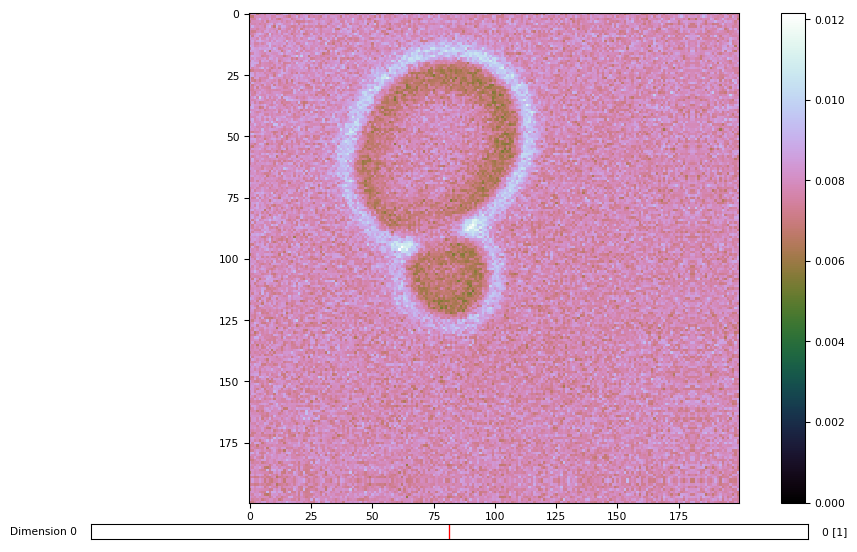

In [108]:
idx = 30
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,0]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

## ResNet with Batchnorm
Each run of the experiment we start with loading a set of pretrained weights from a saved model. This way we have benchmark from which to judge.

In [109]:
sorted(os.listdir('../datasets/yeast_v5/models'))

['Objective_A_Resnet_per_class_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_2.h5',
 'Objective_C_Resnet_per_class_3.h5',
 'Objective_C_Resnet_per_class_balanced_1.h5',
 'Objective_C_Resnet_per_dataset_2.h5',
 'Objective_C_Resnet_per_dataset_3.h5',
 'ResNet5_default_07-24_23-18.h5',
 'ResNet5_default_07-25_15-38.h5',
 'ResNet5_default_07-25_15-38.h5_2',
 'ResNet5_default_07-25_15-38.h5_88acc',
 'ResNet5_default_07-25_15-38.h5adjust_45',
 'ResNet5_default_07-25_15-55.h5',
 'ResNet5_default_07-25_15-55.h5_adj45',
 'ResNet5_v5_batch_adj_07-24_16-46.h5',
 'ResNet5_v5_batch_adj_07-24_18-32.h5',
 'ResNet5_v5_batch_adj_07-24_18-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-11.h5',
 'ResNet5_v5_batch_adj_07-24_19-32.h5',
 'ResNet5_v5_batch_adj_07-24_19-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-59.h5',
 'ResNet5_v5_batch_adj_07-24_20-27.h5',
 'ResNet5_v5_batch_adj_07-25_13-31.h5']

In [139]:
model = ResNet([10, 20, 40, 80, 160], NUM_CLASSES, obj_name="test", tb_log=True)
learn = ConvLearner.from_model_data(model, data)
wd=1e-5

In [140]:
learn.load('ResNet5_default_07-24_23-18')

In [141]:
%time learn.fit(1e-5, 1, wds=wd)

EPOCH 0 ---------------------------------------- STEP 99   
mean: [21.66667 21.04762  4.85714 14.14286 30.19048  5.28571]; stdev: [5.45399 3.63156 1.95876 3.22617 6.39657 3.07281]

[WT]: 90.0%
[mfb1KO]: 70.0%
[mfb1KO_mmr1KO]: 91.43%
[mmm1KO_230]: 91.43%
[mmr1KO]: 87.14%
[num1_110]: 94.29%
epoch      trn_loss   val_loss   accuracy   
    0      0.245106   0.604341   0.857143  
f1 weighted average score: [0.8559]

CPU times: user 15.3 s, sys: 6.11 s, total: 21.4 s
Wall time: 14.2 s


[array([0.60434]), 0.8571428522231087]

[[64  2  0  0  4  0]                         
 [11 51  0  0  8  0]
 [ 0  0 31  0  0  4]
 [ 0  0  0 32  0  3]
 [ 2  5  0  0 63  0]
 [ 0  0  1  0  0 34]]


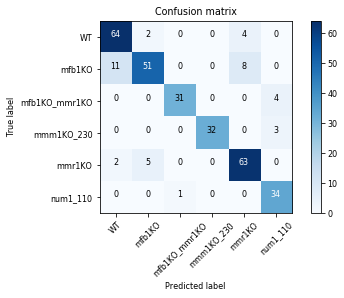

In [142]:
plot_cm()

### From the confusion matrix we can see that the mfb1KO gets confused with mmr1KO13% of the time; lets increase their presence in the batchsize but keep the learning rate small

In [146]:
adjust = {
    1: 100/6 + 10,
    0: 100/6 + 10,
    4: 100/6 + 10,
}
%time learn.fit(1e-4, 2, wds=wd, adjust_class=adjust,save_model)

TypeError: __init__() got an unexpected keyword argument 'save_best_model'

[[67  2  0  0  1  0]                         
 [ 2 64  0  0  4  0]
 [ 0  0 29  0  0  6]
 [ 0  0  0 32  0  3]
 [ 4 12  0  0 54  0]
 [ 0  0  1  0  0 34]]


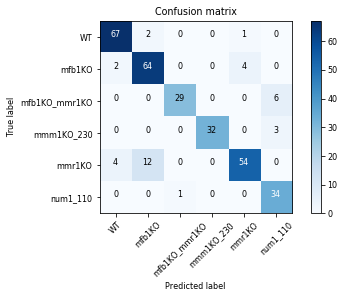

In [145]:
plot_cm()

In [77]:
adjust = {
    1:20,
    4:20
}
%time learn.fit(1e-2, 1, wds=wd, adjust_class=adjust)

  0%|          | 0/21 [00:00<?, ?it/s][294 287  71 195 407  75]
EPOCH 0 ---------------------------------------- STEP 25   
mean: [14.90476 20.90476 14.      14.19048 19.14286 14.14286]; stdev: [4.27512 5.53693 4.68025 6.32169 5.37442 4.09745]

[WT]: 87.14%
[mfb1KO]: 97.14%
[mfb1KO_mmr1KO]: 91.43%
[mmm1KO_230]: 91.43%
[mmr1KO]: 57.14%
[num1_110]: 97.14%
epoch      trn_loss   val_loss   accuracy   
    0      0.380491   0.578201   0.847619  
f1 weighted average score: [0.8444]

CPU times: user 17.9 s, sys: 6.31 s, total: 24.2 s
Wall time: 17.2 s


[array([0.5782]), 0.8476190510250273]

[[61  7  0  0  2  0]                         
 [ 2 68  0  0  0  0]
 [ 0  0 32  0  0  3]
 [ 0  0  0 32  0  3]
 [ 5 21  0  0 44  0]
 [ 0  0  1  0  0 34]]


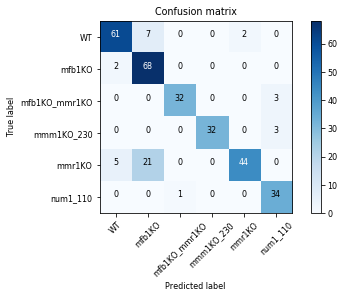

In [78]:
plot_cm()

  0%|          | 0/21 [00:00<?, ?it/s][294 287  71 195 407  75]
EPOCH 0 ---------------------------------------- STEP 26   
mean: [19.61905  0.      20.42857 19.61905 19.47619 18.38095]; stdev: [2.69879 0.      3.47195 5.25063 4.39284 4.18018]

[WT]: 97.14%
[mfb1KO]:  0.0%
[mfb1KO_mmr1KO]: 85.71%
[mmm1KO_230]: 94.29%
[mmr1KO]: 77.14%
[num1_110]: 54.29%
epoch      trn_loss   val_loss   accuracy   
    0      1.649651   3.641405   0.647619  


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 weighted average score: [0.5663]

CPU times: user 18 s, sys: 6.15 s, total: 24.2 s
Wall time: 17.1 s
[[69  0  0  0  1  0]                         
 [28  0  0  0 42  0]
 [ 0  0 28  5  0  2]
 [ 0  0  0 33  0  2]
 [14  0  0  0 56  0]
 [ 0  0 14  2  0 19]]


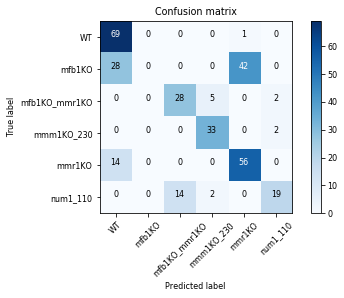

In [79]:
adjust = {
    1:0,
}
%time learn.fit(1e-6, 1, wds=wd, adjust_class=adjust)
plot_cm()

In [66]:
adjust = {
    1:20,
    4:20,
}
%time learn.fit(1e-4, 1, wds=wd, adjust_class=adjust)

  0%|          | 0/21 [00:00<?, ?it/s][294 287  71 195 407  75]
EPOCH 0 ---------------------------------------- STEP 20   
mean: [12.7619  21.14286 15.14286 13.28571 19.47619 15.2381 ]; stdev: [2.32798 4.63204 3.35638 3.95382 3.98353 5.56267]

[WT]: 62.86%
[mfb1KO]: 98.57%
[mfb1KO_mmr1KO]: 77.14%
[mmm1KO_230]: 77.14%
[mmr1KO]: 70.0%
[num1_110]: 94.29%
epoch      trn_loss   val_loss   accuracy   
    0      0.493776   0.813623   0.790476  
f1 weighted average score: [0.7933]

CPU times: user 17.8 s, sys: 6.52 s, total: 24.3 s
Wall time: 17.2 s


[array([0.81362]), 0.7904761897193061]

[[42 19  0  0  9  0]                         
 [ 0 69  0  0  1  0]
 [ 0  0 27  0  0  8]
 [ 0  0  1 27  0  7]
 [ 0 19  0  0 51  0]
 [ 0  0  0  0  3 32]]


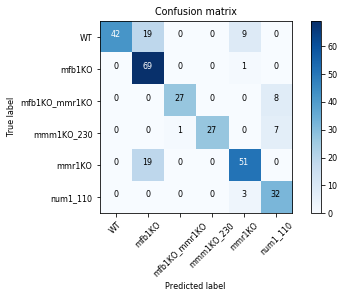

In [67]:
plot_cm()

### now lets do the same thing but increase the learning rate

In [30]:
adjust = {
    4:20,
    1:20,
}
%time learn.fit(1e-5, 1, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85), adjust_class=adjust)

  0%|          | 0/21 [00:00<?, ?it/s][294 287  71 195 407  75]
EPOCH 0 ---------------------------------------- STEP 7    
mean: [14.      22.38095 15.95238 14.2381  17.80952 12.7619 ]; stdev: [4.42934 5.86739 4.96153 4.82952 3.23108 3.22054]

[WT]: 92.86%
[mfb1KO]: 62.86%
[mfb1KO_mmr1KO]: 74.29%
[mmm1KO_230]: 85.71%
[mmr1KO]: 62.86%
[num1_110]: 94.29%
epoch      trn_loss   val_loss   accuracy   
    0      0.358472   0.878279   0.768254  
f1 weighted average score: [0.7694]

CPU times: user 18.3 s, sys: 6.04 s, total: 24.3 s
Wall time: 17.3 s


[array([0.87828]), 0.7682539629557776]

In [36]:
### now lets decrease the presence of mmr

In [37]:
adjust = {
    4:10, # deacreasing the presence of mmr
}
%time learn.fit(1e-3, 1, wds=wd, adjust_class=adjust)

  0%|          | 0/21 [00:00<?, ?it/s][294 287  71 195 407  75]
EPOCH 0 ---------------------------------------- STEP 9    
mean: [17.04762 16.14286 16.47619 19.14286  8.90476 19.38095]; stdev: [4.21422 5.25797 4.56299 4.87252 3.58442 3.64465]

[WT]: 85.71%
[mfb1KO]: 68.57%
[mfb1KO_mmr1KO]: 85.71%
[mmm1KO_230]: 94.29%
[mmr1KO]: 82.86%
[num1_110]: 91.43%
epoch      trn_loss   val_loss   accuracy   
    0      0.817846   0.445107   0.828571  
f1 weighted average score: [0.8278]

CPU times: user 18 s, sys: 6.08 s, total: 24.1 s
Wall time: 17 s


[array([0.44511]), 0.8285714236516801]

[[60  7  0  0  3  0]                         
 [ 7 49  0  0 14  0]
 [ 0  0 30  1  0  4]
 [ 0  0  0 33  0  2]
 [14  3  0  0 53  0]
 [ 0  0  2  0  0 33]]


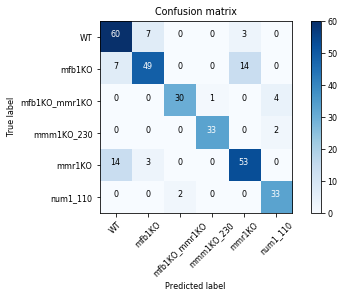

In [38]:
plot_cm()

In [23]:
def plot_cm():# analyze results 
    log_preds, y = learn.TTA(n_aug=1)
    log_preds_mean = np.mean(log_preds, axis=0)
    preds = np.argmax(log_preds_mean, axis=1)
    # cm = confusion_matrix(preds,y)
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, data.classes)

In [ ]:
log_preds = learn.predict()
preds = np.exp(log_preds)
choices = np.argmax(preds,axis=1)

In [ ]:
choices.shape

In [ ]:
is_correct = learn.data.val_y == choices

In [ ]:
list(is_correct).count(True) / 315